# Supervised Learning: Neural Networks

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import theano
import theano.tensor as tt
import pymc3 as pm
from scipy import optimize
from ipywidgets import *
from IPython.display import SVG
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

floatX = theano.config.floatX
theano.config.compute_test_value = 'ignore'

## McCulloch and Pitts Neuron

In 1943, McCulloch and Pitts introduced a mathematical model of a neuron. It consisted of three components:

1. A set of **weights** $w_i$ corresponding to synapses (inputs)
2. An **adder** for summing input signals; analogous to cell membrane that collects charge
3. An **activation function** for determining when the neuron fires, based on accumulated input

The neuron model is shown schematically below. On the left are input nodes $\{x_i\}$, usually expressed as a vector. The strength with which the inputs are able to deliver the signal along the synapse is determined by their corresponding weights $\{w_i\}$. The adder then sums the inputs from all the synapses:

$$h = \sum_i w_i x_i$$

The parameter $\theta$ determines whether or not the neuron fires given a weighted input of $h$. If it fires, it returns a value $y=1$, otherwise $y=0$. For example, a simple **activation function** is using $\theta$ as a simple fixed threshold:

$$y = g(h) = \left\{ \begin{array}{l}
1, \text{if } h \gt \theta \\
0, \text{if } h \le \theta
\end{array} \right.$$

this activation function may take any of several forms, such as a logistic function.

![neuron](http://d.pr/i/9AMK+)

A single neuron is not interesting, nor useful, from a learning perspective. It cannot learn; it simply receives inputs and either fires or not. Only when neurons are joined as a **network** can they perform useful work.

Learning takes place by changing the weights of the connections in a neural network, and by changing the parameters of the activation functions of neurons.

## Perceptron

A collection of McCullough and Pitts neurons, along with a set of input nodes connected to the inputs via weighted edges, is a perceptron, the simplest neural network.

Each neuron is independent of the others in the perceptron, in the sense that its behavior and performance depends only on its own weights and threshold values, and not of those for the other neurons. Though they share inputs, they operate independently.

The number of inputs and outputs are determined by the data. Weights are stored as a `N x K` matrix, with N observations and K neurons, with $w_{ij}$ specifying the weight on the *i*th observation on the *j*th neuron.

![perceptron](http://d.pr/i/4IWA+)

In order to use the perceptron for statistical learning, we compare the outputs $y_j$ from each neuron to the obervation target $t_j$, and adjust the input weights when they do not correspond (*e.g.* if a neuron fires when it should not have).

$$t_j - y_j$$

We use this difference to update the weight $w_{ij}$, based on the input and a desired **learning rate**. This results in an update rule:

$$w_{ij} \leftarrow w_{ij} + \eta (t_j - y_j) x_i$$

After an incremental improvement, the perceptron is shown the training data again, resulting in another update. This is repeated until the performance no longer improves. Having a learning rate less than one results in a more stable learning rate, though this stability is traded off against having to expose the network to the data multiple times. Typical learning rates are in the 0.1-0.4 range.

An additional input node is typically added to the perceptron model, which is a constant value (usually -1, 0, or 1) that acts analogously to an intercept in a regression model. This establishes a baseline input for the case when all inputs are zero.

![bias](http://d.pr/i/105b5+)

## Learning with Perceptrons

1. Initialize weights $w_{ij}$ to small, random numbers.
2. For each t in T iterations
    * compute activation for each neuron *j* connected to each input vector *i*
    $$y_j = g\left( h=\sum_i w_{ij} x_i \right) = \left\{ \begin{array}{l}
1, \text{if } h \gt 0 \\
0, \text{if } h \le 0
\end{array} \right.$$
    * update weights
    $$w_{ij} \leftarrow w_{ij} + \eta (t_j - y_j) x_i$$


This algorithm is $\mathcal{O}(Tmn)$

### Example: Logical functions

Let's see how the perceptron learns by training it on a couple of of logical functions, AND and OR. For two variables `x1` and `x2`, the AND function returns 1 if both are true, or zero otherwise; the OR function returns 1 if either variable is true, or both. These functions can be expressed as simple lookup tables.

In [2]:
AND = pd.DataFrame({'x1': (0,0,1,1), 'x2': (0,1,0,1), 'y': (0,0,0,1)})
AND

,x1,x2,y
0,0,0,0
1,0,1,0
2,1,0,0
3,1,1,1


First, we need to initialize weights to small, random values (can be positive and negative).

In [3]:
w = np.random.randn(3)*1e-4

Then, a simple activation function for calculating $g(h)$:

In [4]:
g = lambda inputs, weights: np.where(np.dot(inputs, weights)>0, 1, 0)

Finally, a training function that iterates the learning algorithm, returning the adapted weights.

In [5]:
def train(inputs, targets, weights, eta, n_iterations):

    # Add the inputs that match the bias node
    inputs = np.c_[inputs, -np.ones((len(inputs), 1))]

    for n in range(n_iterations):

        activations = g(inputs, weights);
        weights -= eta*np.dot(np.transpose(inputs), activations - targets)
        
    return(weights)

Let's test it first on the AND function.

In [6]:
inputs = AND[['x1','x2']]
target = AND['y']

w = train(inputs, target, w, 0.25, 10)

Checking the performance:

In [7]:
g(np.c_[inputs, -np.ones((len(inputs), 1))], w)

array([0, 0, 0, 1])

Thus, it has learned the function perfectly. Now for OR:

In [8]:
OR = pd.DataFrame({'x1': (0,0,1,1), 'x2': (0,1,0,1), 'y': (0,1,1,1)})
OR

,x1,x2,y
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,1


In [9]:
w = np.random.randn(3)*1e-4

In [10]:
inputs = OR[['x1','x2']]
target = OR['y']

w = train(inputs, target, w, 0.25, 20)

In [11]:
g(np.c_[inputs, -np.ones((len(inputs), 1))], w)

array([0, 1, 1, 1])

Also 100% correct.

### Exercise: XOR

Now try running the model on the XOR function, where a one is returned for either `x1` or `x2` being true, but *not* both. What happens here?

In [12]:
XOR = pd.DataFrame({'x1': (0,0,1,1), 'x2': (0,1,0,1), 'y': (0,1,1,1)})
XOR 

,x1,x2,y
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,1


In [13]:
w = np.random.randn(3)*1e-4

In [14]:
inputs = AND[['x1','x2']]
target = AND['y']

w = train(inputs, target, w, 0.25, 10)

In [15]:
g(np.c_[inputs, -np.ones((len(inputs), 1))], w)

array([0, 0, 0, 1])

Let's explore the problem graphically:

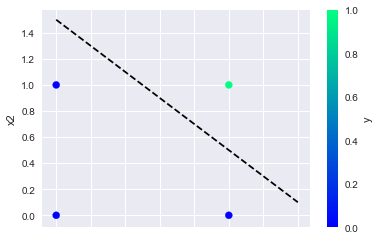

In [16]:
AND.plot(kind='scatter', x='x1', y='x2', c='y', s=50, colormap='winter')
plt.plot(np.linspace(0,1.4), 1.5 - 1*np.linspace(0,1.4), 'k--');

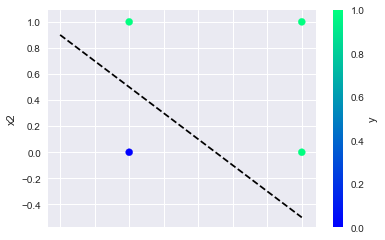

In [17]:
OR.plot(kind='scatter', x='x1', y='x2', c='y', s=50, colormap='winter')
plt.plot(np.linspace(-.4,1), .5 - 1*np.linspace(-.4,1), 'k--');

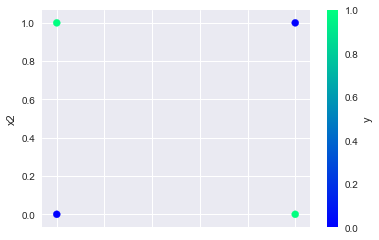

In [18]:
XOR = pd.DataFrame({'x1': (0,0,1,1), 'x2': (0,1,0,1), 'y': (0,1,1,0)})

XOR.plot(kind='scatter', x='x1', y='x2', c='y', s=50, colormap='winter');

The perceptron tries to find a separating hyperplane for the two response classes. Namely, a set of weights that satisfies:

$$\mathbf{x_1}\mathbf{w}^T=0$$

and:

$$\mathbf{x_2}\mathbf{w}^T=0$$

Hence,

$$\begin{aligned}
\mathbf{x}_1\mathbf{w}^T &= \mathbf{x}_2\mathbf{w}^T \\
\Rightarrow (\mathbf{x}_1 - \mathbf{x}_2) \mathbf{w}^T &= 0
\end{aligned}$$

This means that either the norms of $\mathbf{x}_1 - \mathbf{x}_2$ or $\mathbf{w}$ are zero, or the cosine of the angle between them is equal to zero, due to the identity:

$$\mathbf{a}\mathbf{b} = \|a\| \|b\| \cos \theta$$

Since there is no reason for the norms to be zero in general, we need the two vectors to be at right angles to one another. So, we need a weight vector that is perpendicular to the decision boundary.

Clearly, for the XOR function, the output classes are not linearly separable. So, the algorithm does not converge on an answer, but simply cycles through two incorrect solutions.

## Multi-layer Perceptron

The solution to fitting more complex (*i.e.* non-linear) models with neural networks is to use a more complex network that consists of more than just a single perceptron. The take-home message from the perceptron is that all of the learning happens by adapting the synapse weights until prediction is satisfactory. Hence, a reasonable guess at how to make a perceptron more complex is to simply **add more weights**.

There are two ways to add complexity:

1. Add backward connections, so that output neurons feed back to input nodes, resulting in a **recurrent network**
2. Add neurons between the input nodes and the outputs, creating an additional ("hidden") layer to the network, resulting in a **multi-layer perceptron**

The latter approach is more common in applications of neural networks.

![multilayer](http://d.pr/i/14BS1+)

How to train a multilayer network is not intuitive. Propagating the inputs forward over two layers is straightforward, since the outputs from the hidden layer can be used as inputs for the output layer. However, the process for updating the weights based on the prediction error is less clear, since it is difficult to know whether to change the weights on the input layer or on the hidden layer in order to improve the prediction.

Updating a multi-layer perceptron (MLP) is a matter of: 

1. moving forward through the network, calculating outputs given inputs and current weight estimates
2. moving backward updating weights according to the resulting error from forward propagation. 

In this sense, it is similar to a single-layer perceptron, except it has to be done twice, once for each layer (in principle, we can add additional hidden layers, but without sacrificing generality, I will keep it simple).

### Error back-propagation

We update the weights in a MLP using **back-propagation** of the prediction errors, which is essentially a form of gradient descent, as we have used previously for optimization.

First, for the multi-layer perceptron we need to modify the error function, which in the single-layer case was a simple difference between the predicted and observed outputs. Because we will be summing errors, we have to avoid having errors in different directions cancelling each other out, so a sum of squares error is more appropriate:

$$E(t,y) = \frac{1}{2} \sum_i (t_i - y_i)^2$$

It is on this function that we will perform gradient descent, since the goal is to minimize the error. Specificially, we will differentiate with respect to the weights, since it is the weights that we are manipulating in order to get better predictions.

Recall that the error is a function of the threshold function

$$E(\mathbf{w}) = \frac{1}{2} \sum_i (t_i - y_i)^2 = \frac{1}{2} \sum_i \left(t_i - g\left[ \sum_j w_{ij} a_j \right]\right)^2$$

So, we will also need to differentiate that. However, the threshold function we used in the single-layer perceptron was discontinuous, making it non-differentiable. Thus, we need to modify it as well. An alternative is to employ some type of sigmoid function, such as the logistic, which can be parameterized to resemble a threshold function, but varies smoothly across its range.

$$g(h) = \frac{1}{1 + \exp(-\beta h)}$$

In [19]:
logistic = lambda h, beta: 1./(1 + np.exp(-beta * h))

@interact(beta=(-1, 25))
def logistic_plot(beta=5):
    hvals = np.linspace(-2, 2)
    plt.plot(hvals, logistic(hvals, beta))

interactive(children=(IntSlider(value=5, description='beta', max=25, min=-1), Output()), _dom_classes=('widget-interact',))

This has the advantage of having a simple derivative:

$$\frac{dg}{dh} = \beta g(h)(1 - g(h))$$

Alternatively, the hyperbolic tangent function is also sigmoid:

$$g(h) = \tanh(h) = \frac{\exp(h) - \exp(-h)}{\exp(h) + \exp(-h)}$$

In [20]:
hyperbolic_tangent = lambda h: (np.exp(h) - np.exp(-h)) / (np.exp(h) + np.exp(-h))

@interact(theta=(-1, 25))
def tanh_plot(theta=5):
    hvals = np.linspace(-2, 2)
    h = hvals*theta
    plt.plot(hvals, hyperbolic_tangent(h))

interactive(children=(IntSlider(value=5, description='theta', max=25, min=-1), Output()), _dom_classes=('widget-interact',))

Notice that the hyperbolic tangent function asymptotes at -1 and 1, rather than 0 and 1, which is sometimes beneficial, and its derivative is simple:

$$\frac{d \tanh(x)}{dx} = 1 - \tanh^2(x)$$

Performing gradient descent will allow us to change the weights in the direction that optimially reduces the error. The next trick will be to employ the **chain rule** to decompose how the error changes as a function of the input weights into the change in error as a function of changes in the inputs to the weights, mutliplied by the changes in input values as a function of changes in the weights. 

$$\frac{\partial E}{\partial w} = \frac{\partial E}{\partial h}\frac{\partial h}{\partial w}$$

This will allow us to write a function describing the activations of the output weights as a function of the activations of the hidden layer nodes and the output weights, which will allow us to propagate error backwards through the network.

The second term in the chain rule simplifies to:

$$\begin{align}
\frac{\partial h_k}{\partial w_{jk}} &= \frac{\partial \sum_l w_{lk} a_l}{\partial w_{jk}}  \\
&= \sum_l \frac{\partial w_{lk} a_l}{\partial w_{jk}} \\
& = a_j
\end{align}$$

where $a_j$ is the activation of the jth hidden layer neuron.

For the first term in the chain rule above, we decompose it as well:

$$\frac{\partial E}{\partial h_k} = \frac{\partial E}{\partial y_k}\frac{\partial y_k}{\partial h_k} = \frac{\partial E}{\partial g(h_k)}\frac{\partial g(h_k)}{\partial h_k}$$

The second term of this chain rule is just the derivative of the activation function, which we have chosen to have a conveneint form, while the first term simplifies to:

$$\frac{\partial E}{\partial g(h_k)} = \frac{\partial}{\partial g(h_k)}\left[\frac{1}{2} \sum_k (t_k - y_k)^2 \right] = t_k - y_k$$

Combining these, and assuming (for illustration) a logistic activiation function, we have the gradient:

$$\frac{\partial E}{\partial w} = (t_k - y_k) y_k (1-y_k) a_j$$

Which ends up getting plugged into the weight update formula that we saw in the single-layer perceptron:

$$w_{jk} \leftarrow w_{jk} - \eta (t_k - y_k) y_k (1-y_k) a_j$$

Note that here we are *subtracting* the second term, rather than adding, since we are doing gradient descent.

We can now outline the MLP learning algorithm:

1. Initialize all $w_{jk}$ to small random values
2. For each input vector, conduct forward propagation:
    * compute activation of each neuron $j$ in hidden layer (here, sigmoid):
    $$h_j = \sum_i x_i v_{ij}$$
    $$a_j = g(h_j) = \frac{1}{1 + \exp(-\beta h_j)}$$
    * when the output layer is reached, calculate outputs similarly:
    $$h_k = \sum_k a_j w_{jk}$$
    $$y_k = g(h_k) = \frac{1}{1 + \exp(-\beta h_k)}$$
3. Calculate loss for resulting predictions:
    * compute error at output:
    $$\delta_k = (t_k - y_k) y_k (1-y_k)$$
4. Conduct backpropagation to get partial derivatives of cost with respect to weights, and use these to update weights:
    * compute error of the hidden layers:
    $$\delta_{hj} = \left[\sum_k w_{jk} \delta_k \right] a_j(1-a_j)$$
    * update output layer weights:
    $$w_{jk} \leftarrow w_{jk} - \eta \delta_k a_j$$
    * update hidden layer weights:
    $$v_{ij} \leftarrow v_{ij} - \eta \delta_{hj} x_i$$
    
Return to (2) and iterate until learning completes. Best practice is to shuffle input vectors to avoid training in the same order.

Its important to be aware that because gradient descent is a hill-climbing (or descending) algorithm, it is liable to be caught in local minima with respect to starting values. Therefore, it is worthwhile training several networks using a range of starting values for the weights, so that you have a better chance of discovering a globally-competitive solution.

One useful performance enhancement for the MLP learning algorithm is the addition of **momentum** to the weight updates. This is just a coefficient on the previous weight update that increases the correlation between the current weight and the weight after the next update. This is particularly useful for complex models, where falling into local mimima is an issue; adding momentum will give some weight to the previous direction, making the resulting weights essentially a weighted average of the two directions. Adding momentum, along with a smaller learning rate, usually results in a more stable algorithm with quicker convergence. When we use momentum, we lose this guarantee, but this is generally seen as a small price to pay for the improvement momentum usually gives.

A weight update with momentum looks like this:

$$w_{jk} \leftarrow w_{jk} - \eta \delta_k a_j + \alpha \Delta w_{jk}^{t-1}$$

where $\alpha$ is the momentum (regularization) parameter and $\Delta w_{jk}^{t-1}$ the update from the previous iteration.

The multi-layer pereptron is implemented below in the `MLP` class. The implementation uses the scikit-learn interface, so it is uses in the same way as other supervised learning algorithms in that package.

In [21]:
softmax = lambda a: a / np.sum(a, axis=1, keepdims=True)

class MLP:
    
    def __init__(self, alpha=0.01, eta=0.01, n_hidden_dim=25): # 3 hyperparameters 
        
        self.alpha = alpha
        self.eta = eta
        self.n_hidden_dim = n_hidden_dim
        
    # Helper function to evaluate the total loss on the dataset
    def calculate_loss(self, X, y):
        
        # Forward propagation to calculate our predictions
        z1 = X.dot(self.w1) + self.b1
        a1 = np.tanh(z1)
        z2 = a1.dot(self.w2) + self.b2
        exp_scores = np.exp(z2)
        probs = softmax(exp_scores)
        
        # Calculating the loss
        data_loss = -np.log(probs[range(num_examples), y]).sum()
        
        # Add regulatization term to loss (optional)
        data_loss += self.alpha/2 * np.square(self.w1).sum() + np.square(self.w2).sum()
        
        return 1./num_examples * data_loss
        
    # Helper function to predict an output (0 or 1)
    def predict(self, x):

        # Forward propagation
        z1 = x.dot(self.w1) + self.b1
        a1 = np.tanh(z1)
        z2 = a1.dot(self.w2) + self.b2
        exp_scores = np.exp(z2)
        probs = softmax(exp_scores)
        
        return np.argmax(probs, axis=1)
        
        
    def fit(self, X, y, num_passes=20000, print_loss=False, seed=42):
        
        num_examples, nn_input_dim = X.shape
        nn_output_dim = len(set(y))
    
        # Initialize the parameters to random values. We need to learn these.
        np.random.seed(seed)
        self.w1 = np.random.randn(nn_input_dim, self.n_hidden_dim) / np.sqrt(nn_input_dim)
        self.b1 = np.zeros((1, self.n_hidden_dim))
        self.w2 = np.random.randn(self.n_hidden_dim, nn_output_dim) / np.sqrt(self.n_hidden_dim)
        self.b2 = np.zeros((1, nn_output_dim))


        # Gradient descent. For each batch...
        for i in range(num_passes):

            # Forward propagation
            z1 = X.dot(self.w1) + self.b1
            a1 = np.tanh(z1)
            z2 = a1.dot(self.w2) + self.b2
            exp_scores = np.exp(z2)

            # Backpropagation
            delta3 = softmax(exp_scores)
            delta3[range(num_examples), y] -= 1
            dw2 = (a1.T).dot(delta3)
            db2 = np.sum(delta3, axis=0, keepdims=True)
            delta2 = delta3.dot(self.w2.T) * (1 - np.power(a1, 2))
            dw1 = np.dot(X.T, delta2)
            db1 = np.sum(delta2, axis=0)

            # Add regularization terms (b1 and b2 don't have regularization terms)
            dw2 += self.alpha * self.w2
            dw1 += self.alpha * self.w1

            # Gradient descent parameter update
            self.w1 += -self.eta * dw1
            self.b1 += -self.eta * db1
            self.w2 += -self.eta * dw2
            self.b2 += -self.eta * db2

            # Optionally print the loss.
            # This is expensive because it uses the whole dataset, so we don't want to do it too often.
            if print_loss and i % 1000 == 0:
              print("Loss after iteration %i: %f" %(i, calculate_loss(X, y)))


Let's initialize a MLP classifier, specifying the conjugate gradient minimization method.

In [24]:
mlp = MLP()

Now we can confirm that it solves a non-linear classification, using the simple XOR example

In [25]:
X = XOR[['x1','x2']].values
y = XOR['y'].values

In [26]:
mlp.fit(X, y, num_passes=100)

In [27]:
mlp.predict(X)

array([0, 1, 1, 0])

For a somewhat more sophisiticated example, we can use scikit-learn to simulate some data with a non-linear boundary.

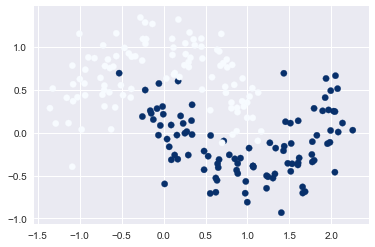

In [28]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = datasets.make_moons(200, noise=0.20)
X = X.astype(np.float32)
y = y.astype(np.int32)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Blues)

In [29]:
clf = MLP(n_hidden_dim=3)
clf.fit(X, y)

In [30]:
def plot_decision_boundary(pred_func, X=X, y=y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Blues)

Text(0.5,1,'Decision Boundary for hidden layer size 3')

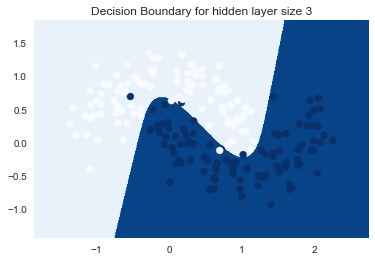

In [31]:
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Decision Boundary for hidden layer size 3")

Since we used the scikit-learn interface, its easy to take advantage of the `metrics` module to evaluate the MLP's performance.

In [32]:
X, y = datasets.make_moons(50, noise=0.20)
X = X.astype(np.float32)
y = y.astype(np.int32)

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy_score(y, clf.predict(X))

0.97999999999999998

In [34]:
confusion_matrix(y, clf.predict(X))

array([[25,  0],
       [ 1, 24]])

# Varying the hidden layer size

In the example above we picked a hidden layer size of 3. Let's now get a sense of how varying the hidden layer size affects the result.

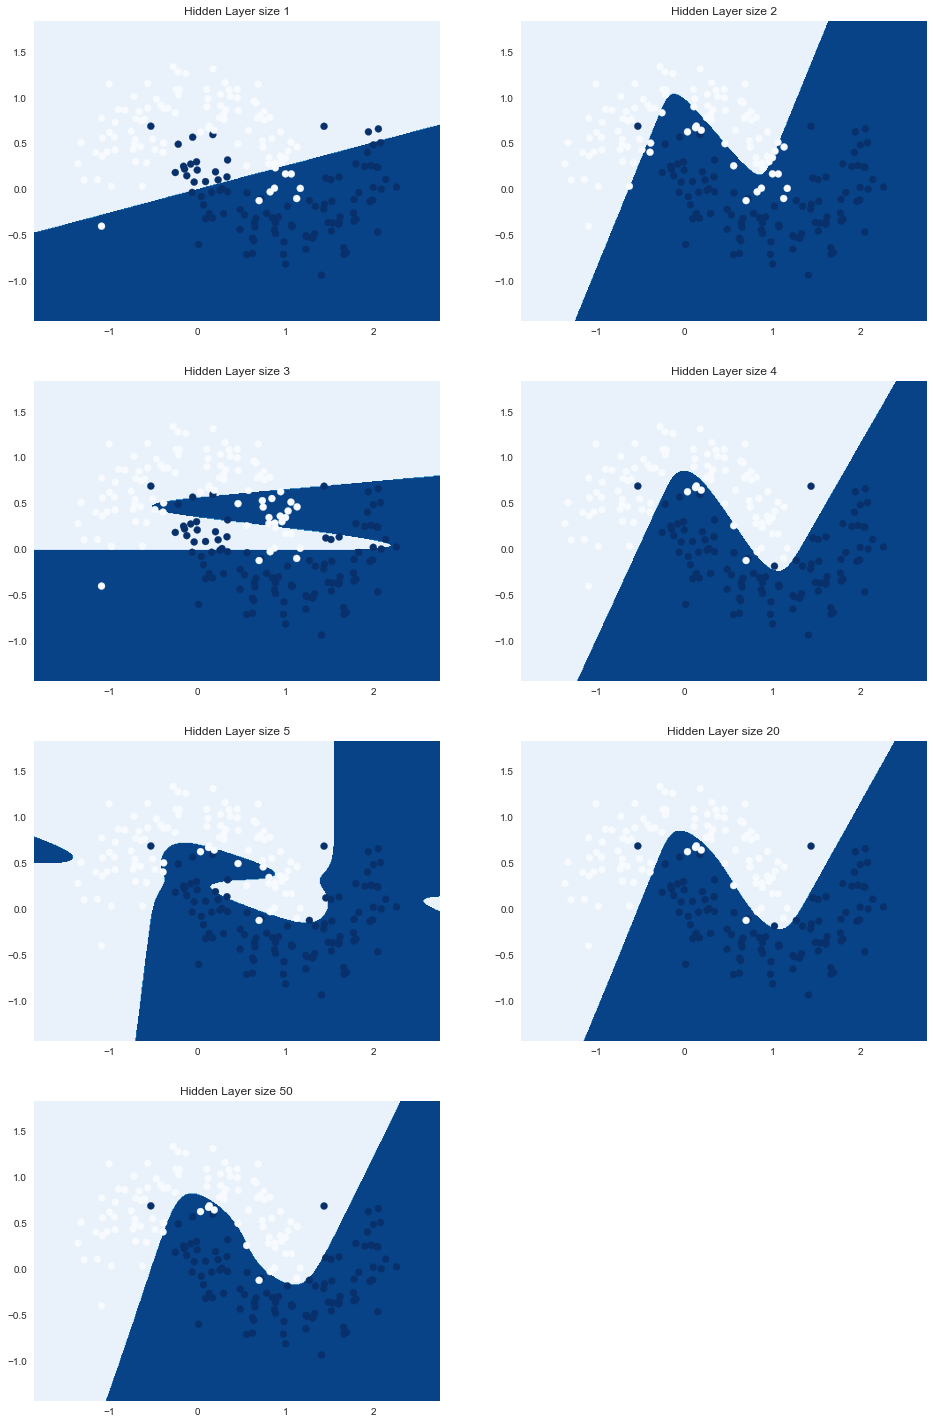

In [35]:
plt.figure(figsize=(16, 32))
n_hidden_dim = [1, 2, 3, 4, 5, 20, 50]
for i, h in enumerate(n_hidden_dim):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % h)
    model = MLP(n_hidden_dim=h)
    model.fit(X, y)
    plot_decision_boundary(lambda x: model.predict(x))

### Neural network specification

The MLP implemented above uses a single hidden layer, though it allows a user-specified number of hidden layer nodes (defaults to 25). It is worth considering whether it is useful having **multiple hidden layers**, and whether more hidden nodes is desirable.

Unfortunately, there is no theory to guide the choice of hidden node number. As a result, we are left to experiment with this parameter, perhaps in some systematic fashion such as cross-validation.

Adding additional layers presents only additional "bookkeeping" overhead to the user, with the weight updating becoming more complicated as layers are added. So, we don't want to add more hidden layers if it does not pay off in performance. It turns out that two or three layers (including the output layer) can be shown to approximate almost any smooth function. Combining 3 sigmoid functions allows local responses to be approximated with arbitrary accuracy. This is sufficient for determining any decision boundary.

### Neural network validation

Just as with other supervised learning algorithms, neural networks can be under- or over-fit to a training dataset. The degree to which a network is trained to a particular dataset depends on how long we train it on that dataset. Every time we run the MLP learning algorithm over a dataset (an **epoch**), it reduces the prediction error for that dataset. Thus, the number of epochs should be tuned as a hyperparameter, stopping when the testing-training error gap begins to widen.

Note that though we can also use cross-validation to tune the number of hidden layers in the network, there is no risk of overfitting by having too many layers.

### Exercise: Epoch tuning for MLPs

The dataset `pima-indians-diabetes.data.txt` in your data folder contains eight measurements taken from a group of Pima Native Americans in Arizona, along with an indicator of the onset of diabetes. Use the MLP class to fit a neural network classifier to this dataset, and use cross-validation to examine the optimal number of epochs to use in training.

1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)
9. Class variable (0 or 1)

In [43]:
pima = pd.read_csv('../data/pima-indians-diabetes.data.txt', header=None)
pima.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [52]:
X = pima.copy()
y = X.pop(8)
X = scale(X) #key is to scale the X values 

In [53]:
clf = MLP()
clf.fit(X, y, num_passes=10000)
# clf = MLP(alpha = 0.1, eta = 0.05, n_hidden_dims = )
# # clf.fit(X.values, y.values)
# clf.fit(X, y, num_passes=10000)

In [54]:
accuracy_score(y.values, clf.predict(X))

1.0

## Example: Mulitilayer perceptron in Theano

Recall the Theano package, introduced earlier in the course; it is designed to evaluate expressions efficiently, and one of its key features is that it automatically differentiates expressions. This saves us from having to code a gradient function by hand. In principle, we could also use Theano to parallelize a neural network using GPUs, but we will not explore that here.

In [55]:
X_train, y_train = datasets.make_moons(50, noise=0.20)
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int32)

In [56]:
# Size definitions
num_examples = len(X_train) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
nn_hdim = 100 # hiden layer dimensionality

# Gradient descent parameters (I picked these by hand)
eta = 0.01 # learning rate for gradient descent
alpha = 0.01 # regularization strength 

## Defining the Computation Graph in Theano

The first thing we need to is define our computations using Theano. We start by defining our input data matrix `X` and our training labels `y`:

In [57]:
# Our data vectors
X = tt.matrix('X') # matrix of doubles
y = tt.lvector('y') # vector of int64

Remember, we have not assigned any values to `X` or `y`. All we have done is defined mathematical expressions for them. We can use these expressions in subsequent calculations. If we want to evaluate an expression we can call its `eval` method. For example, to evaluate the expression `X * 2` for a given value of `X` we could do the following:

In [58]:
(X * 2).eval({X : [[1,1],[2,2]] })

array([[ 2.,  2.],
       [ 4.,  4.]])

Recall also that in addition to tensor objects, Theano also has shared variables which have values associated with them. Their value that is kept in memory and can be shared by all functions that use them. Shared variables can also be updated, and Theano includes low-level optimizations that makes updating them very efficient, especially on GPUs. Our network parameters $W_1, b_1, W_2, b_2$ are constantly updated using gradient descent, so they can be represented by shared variables:

In [59]:
# Shared variables with initial values. We need to learn these.
W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim), name='W1')
b1 = theano.shared(np.zeros(nn_hdim), name='b1')
W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim), name='W2')
b2 = theano.shared(np.zeros(nn_output_dim), name='b2')

Our definition of forward propagation in Theano is identical to our pure Python implementation, except that we now define Theano expressions. 

In [60]:
# Forward propagation
# Note: We are just defining the expressions, nothing is evaluated here!
z1 = X.dot(W1) + b1
a1 = tt.tanh(z1)
z2 = a1.dot(W2) + b2
y_hat = tt.nnet.softmax(z2) # output probabilties

# The regularization term (optional)
loss_reg = 1./num_examples * alpha/2 * (tt.sum(tt.sqr(W1)) + tt.sum(tt.sqr(W2))) 
# the loss function we want to optimize
loss = tt.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg

# Returns a class prediction
prediction = tt.argmax(y_hat, axis=1)

Rather than calling the `eval` method to evaluate our Theano expressions, we can instead define Theano functions for expressions we want to evaluate. To create a function we need to define its inputs and outputs. For example, to calculate the loss, we need to know the values for $X$ and $y$. Once created, we can call it function just like any other Python function.

In [61]:
# Theano functions that can be called from our Python code
forward_prop = theano.function([X], y_hat)
calculate_loss = theano.function([X, y], loss)
predict = theano.function([X], prediction)

# Example call: Forward Propagation
forward_prop([[1,2]])

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


array([[  9.99837340e-01,   1.62660349e-04]])

To get a sense of how Theano constructs a computational graph, we can generate a graphic of the expression tree. Looking at the expressions for $\hat{y}$, we can see that it depends on $z_2$, which in turn depends on $a_1$, $W_2$ and $b_2$, and so on.

In [64]:
!conda install -y Graphviz

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /Users/geenaildefonso/anaconda/envs/bios8366:

The following NEW packages will be INSTALLED:

    graphviz:   2.38.0-4                

The following packages will be SUPERSEDED by a higher-priority channel:

    freetype:   2.7-1        conda-forge --> 2.5.5-2          
    matplotlib: 2.1.0-py36_0 conda-forge --> 2.0.2-np113py36_0
    pillow:     4.3.0-py36_0 conda-forge --> 4.2.1-py36_0     

freetype-2.5.5 100% |################################| Time: 0:00:00   3.47 MB/s
graphviz-2.38. 100% |################################| Time: 0:00:02   4.52 MB/s
pillow-4.2.1-p 100% |################################| Time: 0:00:00 827.06 kB/s
matplotlib-2.0 100% |################################| Time: 0:00:01   8.16 MB/s


In [66]:
!conda install -y pydot

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /Users/geenaildefonso/anaconda/envs/bios8366:

The following NEW packages will be INSTALLED:

    pydot: 1.2.3-py36h7cb6b2e_0

pydot-1.2.3-py 100% |################################| Time: 0:00:00   2.41 MB/s


In [71]:
SVG(theano.printing.pydotprint(forward_prop, var_with_name_simple=True, 
                               compact=True, return_image=True, format='png'))

RuntimeError: ('Failed to import pydot. You must install graphviz and either pydot or pydot-ng for `pydotprint` to work.', 'Install the python package pydot or pydot-ng. Install graphviz.')

This is the *optimized* computational graph that Theano has constructed for our `forward_prop` function. We can also get a textual description:

In [69]:
theano.printing.debugprint(forward_prop)

SoftmaxWithBias [id A] ''   4
 |Dot22 [id B] ''   3
 | |Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)] [id C] ''   2
 | | |Dot22 [id D] ''   1
 | | | |X [id E]
 | | | |W1 [id F]
 | | |InplaceDimShuffle{x,0} [id G] ''   0
 | |   |b1 [id H]
 | |W2 [id I]
 |b2 [id J]


What's left is defining the updates to the network parameters we use with gradient descent. We previously calculated the gradients using backpropagation. Since Theano can automatically differentiate functions for us, we do not have to code them by hand. We need the derivates of our loss function $L$ with respect to our parameters: $\frac{\partial L}{\partial W_2}$, $\frac{\partial L}{\partial b_2}$, $\frac{\partial L}{\partial W_1}$, $\frac{\partial L}{\partial b_1}$:

In [70]:
dW2 = tt.grad(loss, W2)
db2 = tt.grad(loss, b2)
dW1 = tt.grad(loss, W1)
db1 = tt.grad(loss, b1)

Because we defined $W_2, b_2, W_1, b_1$ as shared variables we can use Theano's update mechanism to update their values. The following function (without return value) does a single gradient descent update given $X$ and $y$ as inputs:

In [72]:
gradient_step = theano.function(
    [X, y],
    updates=((W2, W2 - eta * dW2),
             (W1, W1 - eta * dW1),
             (b2, b2 - eta * db2),
             (b1, b1 - eta * db1)))

Note that we don't need to explicitly do a forward propagation here. Theano knows that our gradients depend on our predictions from the forward propagation and it will handle all the necessary calculations for us. It does everything it needs to update the values.

Let's now define a function to train a Neural Network using gradient descent. Again, it's equivalent to what we had in our original code, only that we are now calling the `gradient_step` function defined above instead of doing the calculations ourselves.

In [73]:
# This function learns parameters for the neural network and returns the model.
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(num_passes=20000, print_loss=False):
    
    # Re-Initialize the parameters to random values. We need to learn these.
    # (Needed in case we call this function multiple times)
    np.random.seed(0)
    W1.set_value(np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim))
    b1.set_value(np.zeros(nn_hdim))
    W2.set_value(np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim))
    b2.set_value(np.zeros(nn_output_dim))
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):
        # This will update our parameters W2, b2, W1 and b1!
        gradient_step(X_train, y_train)
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, 
        # so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(X_train, y_train)))

In [74]:
# Build a model with a 3-dimensional hidden layer
build_model(print_loss=True)

Loss after iteration 0: 0.682637
Loss after iteration 1000: 0.311790
Loss after iteration 2000: 0.286436
Loss after iteration 3000: 0.252229
Loss after iteration 4000: 0.214357
Loss after iteration 5000: 0.179542
Loss after iteration 6000: 0.150678
Loss after iteration 7000: 0.127789
Loss after iteration 8000: 0.109909
Loss after iteration 9000: 0.095965
Loss after iteration 10000: 0.085026
Loss after iteration 11000: 0.076355
Loss after iteration 12000: 0.069396
Loss after iteration 13000: 0.063737
Loss after iteration 14000: 0.059075
Loss after iteration 15000: 0.055189
Loss after iteration 16000: 0.051912
Loss after iteration 17000: 0.049122
Loss after iteration 18000: 0.046724
Loss after iteration 19000: 0.044646


Text(0.5,1,'Decision Boundary for hidden layer size 3')

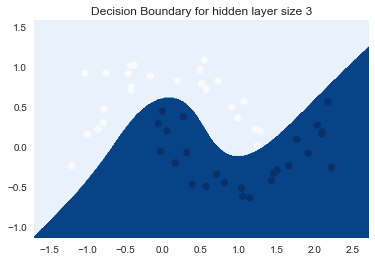

In [75]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(x), X_train, y_train)
plt.title("Decision Boundary for hidden layer size 3")

## Keras

In much the same way that PyMC3 allows Bayesian models to be specified in Theano at a high level, Keras is a high-level neural networks API, written in Python and capable of running on top of either TensorFlow or Theano. Keras is a modular, extensible library that allows for easy construction of deep learning models. It includes classes for building either convolutional networks and recurrent networks, and supports CPU and GPU computation.

If you haven't already, install Keras on your system with either `conda` or `pip`

In [76]:
!conda install -y keras
#!pip install keras

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /Users/geenaildefonso/anaconda/envs/bios8366:

The following NEW packages will be INSTALLED:

    intel-openmp: 2018.0.0-h8158457_8                      
    keras:        2.0.8-py36h39110e4_0                     
    libprotobuf:  3.2.0-0                                  
    mkl:          2017.0.4-h1fae6ae_0                      
    nose:         1.3.7-py36h73fae2b_2                     
    protobuf:     3.2.0-py36_0                             
    tensorflow:   1.1.0-np112py36_0                        
    werkzeug:     0.12.2-py36h168efa1_0                    

The following packages will be UPDATED:

    matplotlib:   2.0.2-np113py36_0                         --> 2.0.2-np112py36_0 

The following packages will be SUPERSEDED by a higher-priority channel:

    numba:        0.35.0-np113py36_6            anaconda    --> 0.35.0-np112py36_0
    numpy:        1.13.3-p

In [ ]:
!pip install keras

When you import Keras' tools into the workspace, it will notify you of which backend it has been configured to use. TensorFlow will be the default, if it is installed on your system.

If you want to edit the default backend configuration, you can specify the `"backend"` variable in `$HOME/.keras/keras.json`:

```json
{
    "floatx": "float32",
    "epsilon": 1e-07,
    "backend": "tensorflow",
    "image_data_format": "channels_last"
}
```

In [77]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

Using TensorFlow backend.


To learn how deep neural networks are constructed in Keras, we will use a famous benchmarking dataset, MNIST. The MNIST database of handwritten digits, which includes a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST.

The original black and white images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field. This results in a vector of 784 values for each image.

In [78]:
from keras.datasets import mnist
from keras.utils import np_utils

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

nb_classes = 10 # Digits from 0 to 9

11354112/11490434 [============================>.] - ETA: 0s

We can convert the raw data for use in Keras.

First, the image data is rehshaped into a tabular format, converted to floats, and scaled.

In [79]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


Finally, the output variable is converted from class vectors to binary class matrices:

In [80]:
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

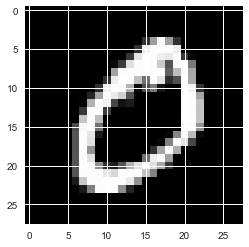

In [81]:
plt.imshow(X_train[1].reshape(28,28), cmap='gray')

### Building the model

The simplest model class in Keras is the `Sequential` class object. It allows networks to be constructed layer by layer, beginning with the data input and terminating with an output layer. Only the input layer requires explicit dimensions to be passed (via the keyword argument `input_dim`); the rest are inferred based on the size of the layer. 

Between layers, we also define an **activation** function for the outputs from the previous layer.

Here is a simple network with two hidden layers. The output layer will be of size 10, corresponding the the number of classes in the dataset.

In [ ]:
model.shape 

In [82]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


Activations can either be used through an `Activation` layer, as we have done here, or through the `activation` argument supported by all forward layers:

```python
model.add(Dense(64))
model.add(Activation('tanh'))
```

This is equivalent to:

```python
model.add(Dense(64, activation='tanh'))
```

For the hidden layers, we have used a **rectified linear unit (RELU)**. This is the simple function:

$$f(x) = \max(0, x)$$

This activation has beens shown to perform well in the training of deep neural networks for supervised learning. It is a sparse activation, and has efficient gradient propagation.

We use the **softmax** activation for the output layer because, like the logistic, it transforms inputs to the unit interval. 

Keras includes utilities for summarizing and visualizing the model. Much like Theano, we can create a GraphViz (`.dot`) format file and convert it to a graphical format of our choosing.

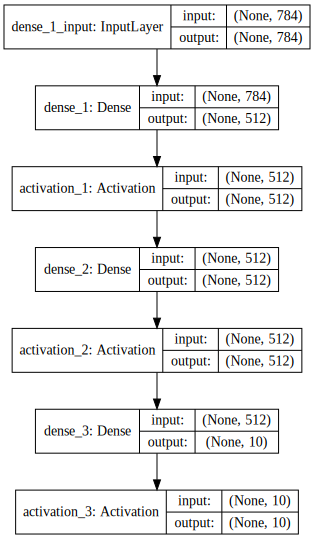

In [83]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Fitting the model

Fitting the model first requires a compilation step, for which we specify three arguments:

- an `optimizer`. This could be the string identifier of an existing optimizer (such as `rmsprop` or `adagrad`), or an instance of the `Optimizer` class. See: [optimizers](/optimizers).
- a `loss` function. This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function (such as `categorical_crossentropy` or `mse`), or it can be an objective function. See: [objectives](/objectives).
- a list of `metrics`. For any classification problem you will want to set this to `metrics=['accuracy']`. A metric could be the string identifier of an existing metric (only `accuracy` is supported at this point), or a custom metric function.

Here we will use `categorical_crossentropy`, since we are doing multi-class classification. The `RMSprop` algorithm is an unpublished, adaptive learning rate method proposed by Geoff Hinton in his [Coursera neural networks course](https://www.coursera.org/learn/neural-networks). It is an improvement on stochastic gradient descent (SGD), wich adjusts the step size to keep it on the same scale as the calculated gradient (SGD has a problem in that learning rates have to scale with 1/T to get convergence).

In [84]:
from keras.optimizers import SGD, Adam, RMSprop

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

The easiest way to train our model is via the `fit` method. This requires the input data (both `X_train` and `y_train`), a `batch_size` (the number of samples per gradient update), and the number of `epochs` over which to train the model. 

In addition, `model.fit` has some optional parameters:

- `verbose`: how often the progress log is printed (0 for no log, 1 for progress bar logging, 2 for one line per epoch)
- `callbacks`: a list of callback objects that perform actions at certain events (see below)
- `validation_split`: splits the training data into training and validation sets. The value passed corresponds to the fraction of the data used for validation ( 
- `validation_data`: when you already have a validation set, pass a list in the format `[input, output]` here. Overrides `validation_split`.
- `shuffle` (default: `True`): shuffles the training data at each epoch.
- `class_weight` and `sample_weight`: used when you want to give different weights during training for certain classes or samples.

In [85]:
batch_size = 128
nb_epoch = 10

history = model.fit(X_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s - loss: 0.2170 - acc: 0.9334 - val_loss: 0.0964 - val_acc: 0.9703
Epoch 2/10
60000/60000 [==============================] - 6s - loss: 0.0812 - acc: 0.9749 - val_loss: 0.0818 - val_acc: 0.9765
Epoch 3/10
60000/60000 [==============================] - 6s - loss: 0.0535 - acc: 0.9837 - val_loss: 0.0748 - val_acc: 0.9776
Epoch 4/10
60000/60000 [==============================] - 6s - loss: 0.0396 - acc: 0.9878 - val_loss: 0.0762 - val_acc: 0.9790
Epoch 5/10
60000/60000 [==============================] - 6s - loss: 0.0300 - acc: 0.9906 - val_loss: 0.1095 - val_acc: 0.9722
Epoch 6/10
60000/60000 [==============================] - 6s - loss: 0.0229 - acc: 0.9928 - val_loss: 0.0848 - val_acc: 0.9800
Epoch 7/10
60000/60000 [==============================] - 6s - loss: 0.0185 - acc: 0.9941 - val_loss: 0.0807 - val_acc: 0.9830
Epoch 8/10
60000/60000 [==============================] - 6s 

### Saving fitted models

Any given model will be composed of two separate parts:

- Its architecture, defined by your Keras code;
- the parameters, learned after training.

In order to reuse a previously trained model, Keras provides methods to serialize both the model architecture and its parameters separately. While it would be possible to use Python standard serialzation method (`pickle`), remember it is not necessarily portable across different Python versions (e.g., a file serialized using pickle on Python 2 will not load on Python 3 and vice-versa). Serializing the model architecture only works when the model does not use any `Lambda` layers; in that case, you have to reinstantiate the model programatically.

To serialize a model architecture, you can use the methods `model.to_json()` and `model.to_yaml()`. The only difference between both methods is the textual format used to serialize (YAML is meant to be more human-readable than JSON).

In [86]:
json_string = model.to_json()
json_string

'{"class_name": "Sequential", "config": [{"class_name": "Dense", "config": {"name": "dense_1", "trainable": true, "batch_input_shape": [null, 784], "dtype": "float32", "units": 512, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Activation", "config": {"name": "activation_1", "trainable": true, "activation": "relu"}}, {"class_name": "Dense", "config": {"name": "dense_2", "trainable": true, "units": 512, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}

To save the model parameters, you can use the method `model.save_weights(filename)`. This saves *all* the model weights to an HDF5 file (which supports saving hierarchical data structures). This method already writes the file to the disk (as opposed to the methods described above). The `ModelCheckpoint` callback described above uses this function to save your model weights.

Having both the serialized architecture and parameters, you do not need the original code that generated the model to execute it anymore. This allows you to avoid the usual guesswork from iteratively running some experiments and fiddling with your code.

In [87]:
model.save_weights('model_weights.h5')

Both the model and the associated weights can then be restored, and reused for other datasets.

In [88]:
from keras.models import model_from_json

model = model_from_json(json_string)
model.load_weights('model_weights.h5')

### Exercise

Build a multi-layer neural network to predict wine varietals using the wine chemistry dataset.

In [89]:
wine = pd.read_table("../data/wine.dat", sep='\s+')

attributes = ['Alcohol',
            'Malic acid',
            'Ash',
            'Alcalinity of ash',
            'Magnesium',
            'Total phenols',
            'Flavanoids',
            'Nonflavanoid phenols',
            'Proanthocyanins',
            'Color intensity',
            'Hue',
            'OD280/OD315 of diluted wines',
            'Proline']

grape = wine.pop('region')
y = grape.values
wine.columns = attributes
X = wine.copy()
# X = wine[['Alcohol', 'Proline']].values

In [91]:
X.shape 

(178, 13)

In [102]:
model = Sequential()
model.add(Dense(512, input_shape=(178,)))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               91648     
_________________________________________________________________
activation_16 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_17 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                5130      
_________________________________________________________________
activation_18 (Activation)   (None, 10)                0         
Total params: 359,434
Trainable params: 359,434
Non-trainable params: 0
_________________________________________________________________


In [103]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [104]:
model.fit(X, y, batch_size = 100, epochs = 15)

ValueError: Error when checking input: expected dense_16_input to have shape (None, 178) but got array with shape (178, 13)

## Bayesian Neural Networks in PyMC3

Bayesian deep learning combines deep neural networks with probabilistic methods to provide information about the **uncertainty** associated with its predictions. Not only is accounting for prediction uncertainty important for real-world applications, it is also be useful in training. For example, we could train the model specifically on samples it is most uncertain about.

We can also quantify the uncertainty in our estimates of network weights, which could inform us about the **stability** of the learned representations of the network.

In classical neural networks, weights are often L2-regularized to avoid overfitting, which corresponds exactly to Gaussian priors over the weight coefficients. We could, however, imagine all kinds of other priors, like spike-and-slab to enforce sparsity (this would be more like using the L1-norm).

If we wanted to train a network on a new object recognition data set, we could bootstrap the learning by placing informed priors centered around weights retrieved from other pre-trained networks, like [GoogLeNet](https://arxiv.org/abs/1409.4842). 

Additionally, a very powerful approach in Probabilistic Programming is **hierarchical modeling**, which allows pooling of things that were learned on sub-groups to the overall population. Applied here, individual neural nets can be applied to sub-groups based on sharing information from the overall population. 

Let's generate another simulated classification dataset:

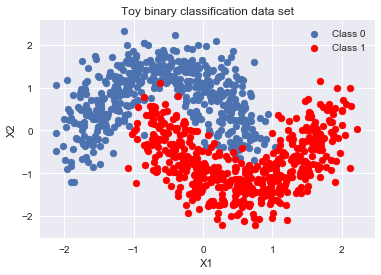

In [105]:
X, y = datasets.make_moons(noise=0.2, n_samples=1000)
X = scale(X)

fig, ax = plt.subplots()
ax.scatter(X[y==0, 0], X[y==0, 1], label='Class 0')
ax.scatter(X[y==1, 0], X[y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X1', ylabel='X2', title='Toy binary classification data set');

The scaling performed above should result in faster training.

We first create training and test sets, and convert the training set to Theano tensors.

In [106]:
X = X.astype(floatX)
y = y.astype(floatX)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

ann_input = theano.shared(X_train)
ann_output = theano.shared(y_train)

Using standard normal deviates for initial values will facilitate convergence.

In [107]:
n_hidden = 5

init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_out = np.random.randn(n_hidden).astype(floatX)

Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem.

In [108]:
with pm.Model() as neural_network:
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                             shape=(X.shape[1], n_hidden), 
                             testval=init_1)

    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                            shape=(n_hidden, n_hidden), 
                            testval=init_2)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                              shape=(n_hidden,), 
                              testval=init_out)

    # Build neural-network using tanh activation function
    act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                     weights_in_1))
    act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                     weights_1_2))
    act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                          weights_2_out))

    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=ann_output,
                       total_size=y_train.shape[0] # IMPORTANT for minibatches
                      )

We could use Markov chain Monte Carlo sampling, which works pretty well in this case, but this will become very slow as we scale our model up to deeper architectures with more layers.

Instead, we will use the the ADVI variational inference algorithm. This is much faster and will scale better. Note, that this is a mean-field approximation so we ignore correlations in the posterior.

In [109]:
with neural_network:
    approx = pm.fit(n=30000)

Average Loss = 140.1: 100%|██████████| 30000/30000 [00:31<00:00, 948.07it/s] 
Finished [100%]: Average Loss = 140.01


As samples are more convenient to work with, we can very quickly draw samples from the variational approximation using the `sample` method.

In [110]:
trace = approx.sample(draws=5000)

Plotting the objective function (ELBO) we can see that the optimization slowly improves the fit over time.

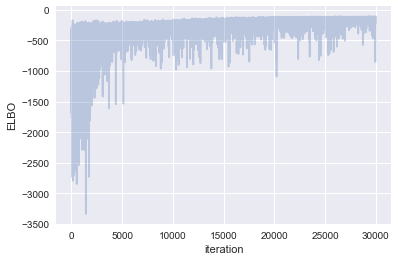

In [111]:
plt.plot(-approx.hist, alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

Now that we trained our model, lets predict on the hold-out set using a posterior predictive check (PPC). 

1. We can use [`sample_ppc()`](../api/inference.rst) to generate new data (in this case class predictions) from the posterior (sampled from the variational estimation).
2. To improve performance, is better to get the node directly and build theano graph using our approximation (`approx.sample_node`)

In [112]:
# We can get predicted probability from model
neural_network.out.distribution.p

sigmoid.0

In [113]:
# create symbolic input
x = tt.matrix('X')
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = tt.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(neural_network.out.distribution.p, 
                                   size=n,
                                   more_replacements={ann_input: x})
# It is time to compile the function
# No updates are needed for Approximation random generator 
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x, n], _sample_proba)

In [114]:
pred = sample_proba(X_test, 500).mean(0) > 0.5

In [115]:
print('Accuracy = {:0.1f}%'.format((y_test == pred).mean() * 100))

Accuracy = 95.3%


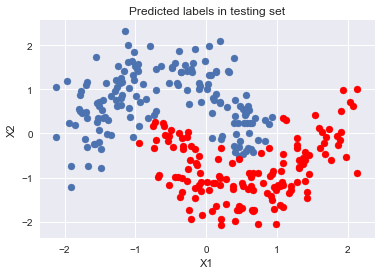

In [116]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X1', ylabel='X2');

Let's look at what the classifier has learned.

For this, we evaluate the class probability predictions on a grid over the whole input space.

In [117]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [118]:
ppc = sample_proba(grid_2d ,500)

The result is a probability surface corresponding to the model predictions.

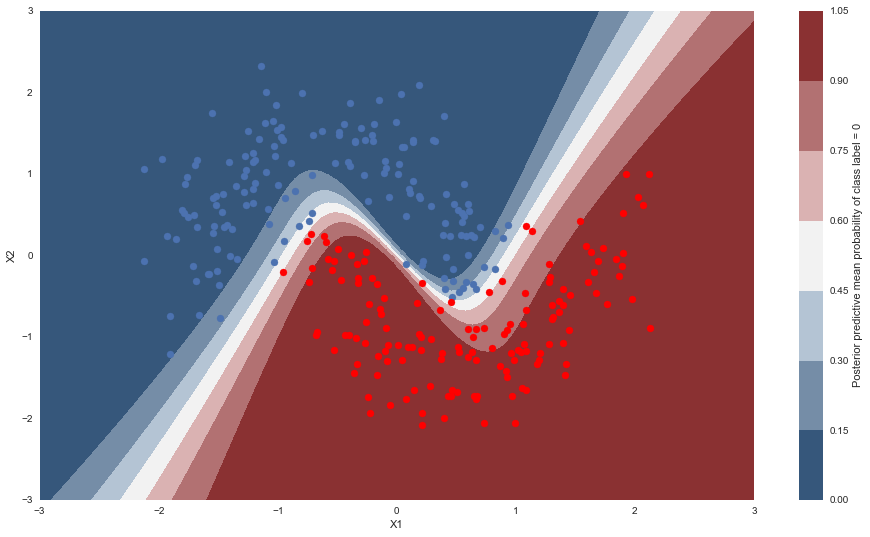

In [119]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

However, unlike a classical neural network, we can also look at the standard deviation of the posterior predictive to get a sense for the uncertainty in our predictions. 

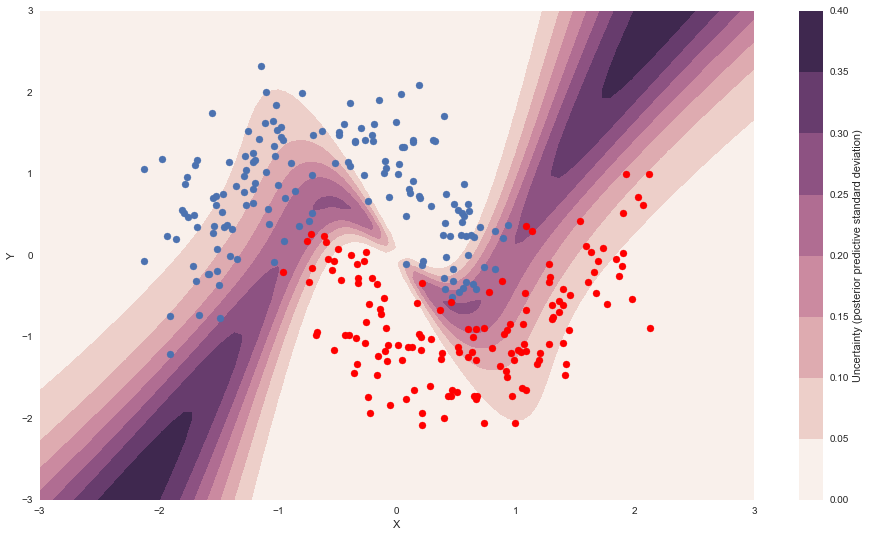

In [120]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

## References

T. Hastie, R. Tibshirani and J. Friedman. (2009) [Elements of Statistical Learning: Data Mining, Inference, and Prediction](http://statweb.stanford.edu/~tibs/ElemStatLearn/), second edition. Springer.

X. Glorot, A. Bordes and Y. Bengio (2011). [Deep sparse rectifier neural networks (PDF)](http://proceedings.mlr.press/v15/glorot11a/glorot11a.pdf). AISTATS.

T. Wiecki and M. Kochurov. (2017) [Variational Inference: Bayesian Neural Networks](http://docs.pymc.io/notebooks/bayesian_neural_network_advi.html)

S. Marsland. (2009) [Machine Learning: An Algorithmic Perspective](Machine Learning: An Algorithmic Perspectivehttp://seat.massey.ac.nz/personal/s.r.marsland/MLBook.html). CRC Press.

D. Rodriguez. (2013) [Basic [1 hidden layer] neural network on Python](http://danielfrg.com/blog/2013/07/03/basic-neural-network-python/).

D. Britz. (2015) [Implementing a Neural Network from Scratch](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/)